In [1]:
# IMPORTS
import os
from datasets import Audio, DatasetDict
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import set_seed as t_set_seed
import torch
import torch.nn as nn
from torchvision import transforms
import torchaudio 
import torchaudio.transforms as T
import numpy as np
from datasets import Dataset
import random
from PIL import Image, ImageOps
import evaluate
from transformers import EvalPrediction
from peft import LoraConfig, get_peft_model
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight as sk_compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import shutil, os
import librosa
import math

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed):
    #random.seed(seed) 
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    t_set_seed(seed)

In [ ]:
# PARAMETERS
training_size = int(input("Enter the amount of spectrograms per class to train on (0 for all): ")) # Number of spectrograms per class to use for training (0 for all)
segments_path = "./segments"
output_dir = "./vit-base-manuai" # Fine-tuned model output directory

model_name = "google/vit-base-patch16-224-in21k"
if os.path.exists("./manuai_checkpoints/preprocessor_config.json"): # If the model has already been fine-tuned, use that as the base (previous checkpoints)
    model_name = "./manuai_checkpoints"

processor = ViTImageProcessor.from_pretrained(model_name)  # Use the processor from the pre-trained model
sample_rate = 22050
epochs = 30
batch_size = 16
n_proc = 3 # Number of processes for parallel processing
seed = 42
segment_len = 4.0
lora_rank = 16
image_size = 224  # ViT base model image size
spectrogram_mode = "log-mel"

training_args = TrainingArguments(
    output_dir="./manuai_checkpoints", 
    learning_rate=1e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=False, 
    bf16=False,
    logging_steps=100,
    report_to="tensorboard",
    save_total_limit=3,
    metric_for_best_model="eval_f1",
    greater_is_better=True
)
set_seed(seed)

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

target_frames = 256
hop_length = (segment_len * sample_rate) // target_frames
hop_length = 2 ** int(np.floor(np.log2(hop_length)))
n_fft = hop_length * 4
n_mels = target_frames

# Set up dataset
Defines the labels
Load all files
Assign ID to labels
Create dataset of `training_size` per specie, and augment if not enough samples.

In [4]:
# IMPORT DATA
def augment_audio(sample):
    """
    Apply random augmentations to the audio sample.
    """
    augmentations = [
        #lambda x: T.TimeStretch()(x.unsqueeze(0), random.uniform(0.8, 1.2)).squeeze(0), # Time stretch
        lambda x: T.PitchShift(sample_rate, n_steps=random.randint(-2, 2))(x), # Pitch shift
        lambda x: x + torch.randn_like(x) * 0.005,  # Gaussian noise
        lambda x: T.FrequencyMasking(freq_mask_param=10)(x),  # Frequency masking
    ]

    num_aug = random.randint(1, len(augmentations)) # Number of augmentations to apply
    aug_funcs = random.sample(augmentations, num_aug) # Randomly select augmentation functions

    for augment in aug_funcs:
        sample = augment(sample) # Apply each augmentation

    return sample

def load_audio_segments():
    """
    Load audio segments for each label, including augmentation if needed.
    """
    for label in labels:
        files = files_labels[label]
        if training_size > 0 and len(files) > training_size:
            selected_files = random.sample(files, training_size)
        else:
            selected_files = files
            diff = training_size - len(selected_files)
            # Yield augmented samples directly if not enough originals
            if diff > 0:
                if len(selected_files) > 0:
                    for f in random.choices(selected_files, k=diff):
                        waveform, sr = torchaudio.load(f)
                        if sr != sample_rate:
                            waveform = T.Resample(sr, sample_rate)(waveform)
                            sr = sample_rate
                        augmented = augment_audio(waveform)
                        yield {
                            "audio": {"array": augmented.squeeze().detach().numpy(), "path": f, "sampling_rate": sr},
                            "label": label_to_id[label]
                        }
        # Yield original samples
        for file_path in selected_files:
            waveform, sr = torchaudio.load(file_path)
            if sr != sample_rate:
                waveform = T.Resample(sr, sample_rate)(waveform)
                sr = sample_rate
            yield {
                "audio": {"array": waveform.squeeze().detach().numpy(), "path": file_path, "sampling_rate": sr},
                "label": label_to_id[label]
            }

labels = sorted(os.listdir(segments_path))
label_to_id = {lbl: i for i, lbl in enumerate(labels)}
id_to_label = {i: lbl for lbl, i in label_to_id.items()}

# Collect original files by label
files_labels = {label: [] for label in labels}
for root, dirs, files in os.walk(segments_path):
    for file in files:
        if file.endswith(".wav"):
            label = os.path.splitext(file)[0].split('_')[1]
            files_labels[label].append(os.path.join(root, file))

dataset = Dataset.from_generator(load_audio_segments)

print("Final label order:", labels)

if dataset:
    print(f"✅ Dataset created successfully with {len(dataset)} samples.")
else:
    print("❌ Dataset creation failed.")

# Example data
print(dataset[0])

Final label order: ['bellbird', 'fantail', 'kaka', 'morepork', 'robin', 'saddleback', 'silvereye', 'tomtit', 'tui', 'whitehead']
✅ Dataset created successfully with 8000 samples.
{'audio': {'array': [-0.1346435546875, -0.10809326171875, -0.054443359375, -0.013671875, -0.01629638671875, -0.060302734375, -0.11431884765625, -0.132080078125, -0.100616455078125, -0.045623779296875, -0.01025390625, -0.019012451171875, -0.06158447265625, -0.10723876953125, -0.120452880859375, -0.09820556640625, -0.053192138671875, -0.0186767578125, -0.02117919921875, -0.061248779296875, -0.106689453125, -0.118804931640625, -0.091400146484375, -0.04315185546875, -0.014068603515625, -0.0234375, -0.06414794921875, -0.102874755859375, -0.110687255859375, -0.087066650390625, -0.0506591796875, -0.02862548828125, -0.037506103515625, -0.07073974609375, -0.105194091796875, -0.11602783203125, -0.0941162109375, -0.054168701171875, -0.028961181640625, -0.036773681640625, -0.06915283203125, -0.103424072265625, -0.11129760

# Generate and plot spectrograms

In [ ]:
# CONVERT AUDIO TO MEL SPECTROGRAMS
def convert_to_mel_spectrogram(sample):
    """
    Convert audio sample to Mel spectrogram for ViT-based bird sound classification.

    """
    audio = sample["audio"]
    waveform = torch.tensor(audio["array"], dtype=torch.float32)
    sample_rate = audio["sampling_rate"]

    # Ensure waveform is 2D (1, time)
    if waveform.ndim == 1:
        waveform = waveform.unsqueeze(0)

    # Configure Mel spectrogram for bird sounds
    mel_spec_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=n_fft,
        n_mels=n_mels,
        f_min=100,
        f_max=10000,
    )

    # Generate Mel spectrogram
    mel_spec = mel_spec_transform(waveform).squeeze(0).numpy()
    y = librosa.power_to_db(mel_spec, ref=np.max)
    sample["log_mel"] = y

    # Process spectrogram based on mode
    if spectrogram_mode == "log-mel":
        # Convert to log scale (decibels)
        y = np.clip(y, -80, 0)
        y = ((y + 80) / 80 * 255).astype(np.uint8)
        y = np.stack([y] * 3, axis=-1)  # (n_mels, time, 3)
    elif spectrogram_mode == "delta3":
        # Log-Mel with delta and delta-delta features
        delta = librosa.feature.delta(y)
        delta2 = librosa.feature.delta(y, order=2)
        y = np.stack([y, delta, delta2], axis=-1)  # (n_mels, time, 3)
    else:
        raise ValueError(f"Unknown spectrogram mode: {spectrogram_mode}")

    # Convert to RGB image
    img = Image.fromarray(y).convert("RGB")
    img = ImageOps.pad(img, (image_size, image_size), color=(0, 0, 0))  # pad to 224x224 without stretching
    
    sample["image"] = img
    return sample

def augment_spectrogram(spectrogram, time_mask_max=20, freq_mask_max=10, num_time_masks=1, num_freq_masks=1):
    """
    Apply SpecAugment-style masking to a spectrogram.
    """
    y = spectrogram.copy()
    
    H, W = y.shape[:2]
    
    # Apply frequency masks
    for _ in range(num_freq_masks):
        f = random.randint(0, freq_mask_max)
        f0 = random.randint(0, max(H - f, 1))
        if y.ndim == 2:
            y[f0:f0+f, :] = 0
        else:
            y[f0:f0+f, :, :] = 0
    
    # Apply time masks
    for _ in range(num_time_masks):
        t = random.randint(0, time_mask_max)
        t0 = random.randint(0, max(W - t, 1))
        if y.ndim == 2:
            y[:, t0:t0+t] = 0
        else:
            y[:, t0:t0+t, :] = 0
    
    return y

def transform(example):
    # Convert PIL image to tensor using processor
    #print(example)
    inputs = processor(images=example["image"], return_tensors="pt", do_normalize=True)
    
    # Remove batch dimension
    example["pixel_values"] = inputs["pixel_values"].squeeze(0)
    return example

dataset = dataset.map(
    convert_to_mel_spectrogram,
    remove_columns=["audio"],
    num_proc=n_proc,
)

dataset = dataset.map(
    transform,
    remove_columns=["image"],
    num_proc=n_proc,
)

print(f"Generated {len(dataset)} mel spectrograms.")
print(dataset.features)
print("Data ready for training.")

Generated 8000 mel spectrograms.
{'label': Value('int64'), 'pixel_values': List(List(List(Value('float32'))))}
Data ready for training.


In [ ]:
# Display 5 random spectrograms and their labels
for i in random.sample(range(len(dataset)), 5):
    y_vis = dataset[i]["log_mel"]
    y_norm = (y_vis - y_vis.min()) / (y_vis.max() - y_vis.min())
    plt.subplot(1, 5, i+1)
    plt.imshow(y_norm, aspect='auto', origin='lower')
    plt.title(f"Sample {i} - Label: {id_to_label[dataset[i]['label']]}")
    plt.axis("off")
    plt.colorbar()

NameError: name 'random' is not defined

# Set up Model architecture

In [7]:
# SET UP MODEL

def trainable_parameters(model):
    params, trainable = 0, 0
    
    for _, p in model.named_parameters():
        params += p.numel()
        trainable += p.numel() if p.requires_grad else 0

    return f"{model.__class__.__name__} trainable parameters: {trainable:,}/{params:,} ({100 * trainable / params:.2f}%)"

def collate_fn(batch):
    return {
        "pixel_values": torch.stack([torch.tensor(item["pixel_values"]) for item in batch]),  # (batch_size, 3, image_size, image_size)
        "labels": torch.tensor([item["label"] for item in batch], dtype=torch.long)
    }

def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    # Overall metrics
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    prec = precision_metric.compute(predictions=preds, references=labels, average="weighted")["precision"]
    rec = recall_metric.compute(predictions=preds, references=labels, average="weighted")["recall"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    auc = roc_auc_score(labels, torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy(), multi_class='ovr', average='macro')

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
        #"class_accuracy": class_acc,
        #"class_precision": class_prec,
        #"class_recall": class_rec,
    }

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        self.loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = self.loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

train, test = dataset.train_test_split(test_size=0.3, seed=seed).values()
dataset = DatasetDict({"train": train, "test": test})

# Model Architecture
processor = ViTImageProcessor.from_pretrained(model_name)
callbacks = [EarlyStoppingCallback(early_stopping_patience=4)]
base_model = ViTForImageClassification.from_pretrained(
    model_name, 
    num_labels=len(labels),
    id2label=id_to_label,
    label2id=label_to_id
)

lora = LoraConfig(
    r=lora_rank,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "key", "value", "dense"], # Attention & MLP layers
    modules_to_save=["classifier"]
)

model = get_peft_model(base_model, lora)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

train_labels = np.array(dataset["train"]["label"], dtype=int)
present_classes = np.unique(train_labels)
present_weights = sk_compute_class_weight(
    class_weight="balanced",
    classes=present_classes,
    y=train_labels
).astype("float32")

num_labels_total = len(labels)  # based on your id2label/label2id
weight_vec = np.ones(num_labels_total, dtype="float32")
for cls_id, w in zip(present_classes, present_weights):
    weight_vec[int(cls_id)] = float(w)

weight_vec = weight_vec * (num_labels_total / weight_vec.sum())

class_weights = torch.tensor(weight_vec, dtype=torch.float32, device=device)
print("Class weights:", class_weights)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    tokenizer=processor,
    data_collator=collate_fn,
    callbacks=callbacks,
)

for i in range(num_labels_total):
    print(f"{i:2d}  {id_to_label[i]:12s}  weight={class_weights[i].item():.3f}")

print(trainable_parameters(model))
print("Ready to begin training...")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Class weights: tensor([1.0051, 1.0310, 0.9891, 1.0087, 1.0033, 0.9856, 1.0253, 0.9943, 0.9669,
        0.9908], device='mps:0')
 0  bellbird      weight=1.005
 1  fantail       weight=1.031
 2  kaka          weight=0.989
 3  morepork      weight=1.009
 4  robin         weight=1.003
 5  saddleback    weight=0.986
 6  silvereye     weight=1.025
 7  tomtit        weight=0.994
 8  tui           weight=0.967
 9  whitehead     weight=0.991
PeftModel trainable parameters: 2,661,898/88,468,244 (3.01%)
Ready to begin training...


/var/folders/m9/5g7zcttx2sx_y5pwg05xn1dh0000gn/T/ipykernel_22404/3859410211.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


# Train the model

In [8]:
# TRAIN MODEL
result = trainer.train()
trainer.log_metrics("train", result.metrics)
trainer.save_metrics("train", result.metrics)
trainer.save_model()  # Saves the tokenizer too for easy upload
trainer.save_state() # Save the trainer state

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,2.102300,1.780938,0.428750,0.433843,0.428750,0.420096,0.804138
2,1.553200,1.282795,0.587083,0.622858,0.587083,0.590911,0.903960
3,1.097900,1.005054,0.686250,0.709968,0.686250,0.686099,0.943597
4,0.789000,0.837855,0.737500,0.751574,0.737500,0.737059,0.958299
5,0.638200,0.714369,0.767917,0.779955,0.767917,0.769550,0.968111
6,0.463900,0.632192,0.797083,0.806558,0.797083,0.796743,0.974989
7,0.339200,0.635581,0.798750,0.804883,0.798750,0.797724,0.975241
8,0.263600,0.557571,0.820417,0.828594,0.820417,0.822007,0.979557
9,0.169500,0.593009,0.820000,0.834288,0.820000,0.824042,0.978806
10,0.121600,0.557294,0.830417,0.835661,0.830417,0.832022,0.980368


/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.war

***** train metrics *****
  epoch                    =         21.0
  total_flos               = 8751115194GF
  train_loss               =       0.3649
  train_runtime            =   3:45:33.92
  train_samples_per_second =       12.413
  train_steps_per_second   =        0.388


# Evaluate the model

In [9]:
# EVALUATE MODEL
metrics = trainer.evaluate(eval_dataset=dataset["test"])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


***** test metrics *****
  epoch                   =       21.0
  eval_accuracy           =      0.855
  eval_auc                =     0.9816
  eval_f1                 =     0.8546
  eval_loss               =     0.6543
  eval_precision          =     0.8551
  eval_recall             =      0.855
  eval_runtime            = 0:02:23.99
  eval_samples_per_second =     16.667
  eval_steps_per_second   =      1.042


# Check metrics of fine-tuned model

{'eval_loss': 0.654295027256012, 'eval_accuracy': 0.855, 'eval_precision': 0.8551200875520709, 'eval_recall': 0.855, 'eval_f1': 0.8545937187466014, 'eval_auc': 0.9815814856167118, 'eval_runtime': 143.9962, 'eval_samples_per_second': 16.667, 'eval_steps_per_second': 1.042, 'epoch': 21.0}
Overall accuracy: 0.85
Overall precision: 0.86
Overall recall: 0.85
Overall F1 Score: 0.85


/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy per class:
bellbird: 0.79
fantail: 0.82
kaka: 0.84
morepork: 0.99
robin: 0.88
saddleback: 0.89
silvereye: 0.91
tomtit: 0.91
tui: 0.67
whitehead: 0.84
Precision & Recall per class
bellbird: Precision: 0.82, Recall: 0.79
fantail: Precision: 0.90, Recall: 0.82
kaka: Precision: 0.81, Recall: 0.84
morepork: Precision: 0.93, Recall: 0.99
robin: Precision: 0.89, Recall: 0.88
saddleback: Precision: 0.90, Recall: 0.89
silvereye: Precision: 0.93, Recall: 0.91
tomtit: Precision: 0.85, Recall: 0.91
tui: Precision: 0.69, Recall: 0.67
whitehead: Precision: 0.81, Recall: 0.84


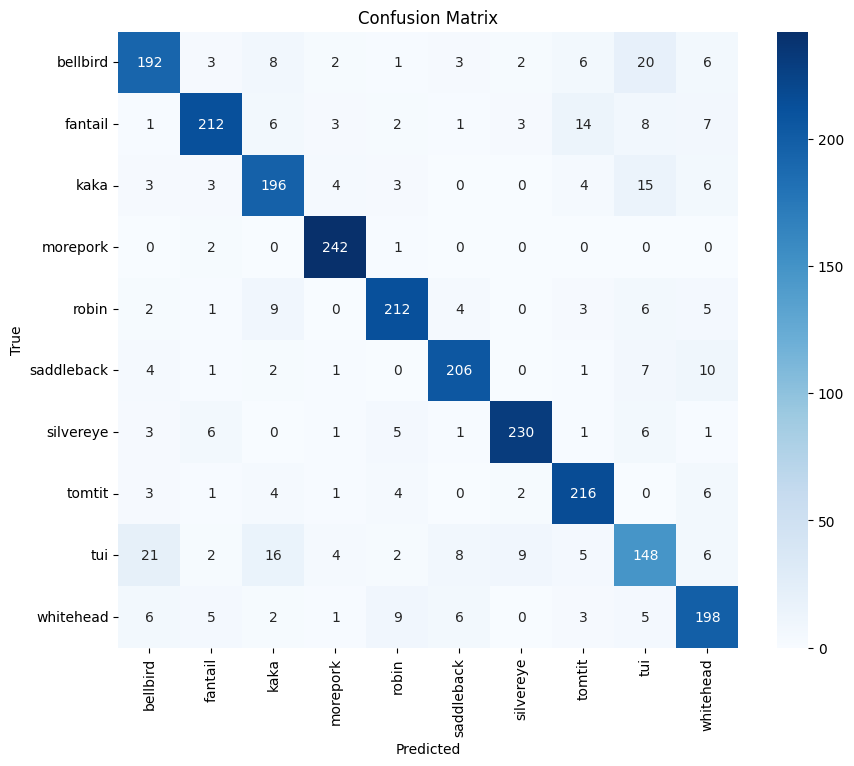

In [10]:
# MODEL METRIC EVALUATION REPORT

# Overall 
print(metrics)
print(f"Overall accuracy: {metrics['eval_accuracy']:.2f}")
print(f"Overall precision: {metrics['eval_precision']:.2f}")
print(f"Overall recall: {metrics['eval_recall']:.2f}")
print(f"Overall F1 Score: {metrics['eval_f1']:.2f}")

predictions = trainer.predict(dataset["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

accuracy_per_class = {}
for i, label_name in enumerate(labels):
    idx = (y_true == i) 
    accuracy_per_class[label_name] = (y_pred[idx] == y_true[idx]).mean()

print("Accuracy per class:")
for label, acc in accuracy_per_class.items():
    print(f"{label}: {acc:.2f}")

print(f"Precision & Recall per class")
for i, label_name in enumerate(labels):
    precision = precision_score(y_true, y_pred, average=None)[i]
    recall = recall_score(y_true, y_pred, average=None)[i]
    print(f"{label_name}: Precision: {precision:.2f}, Recall: {recall:.2f}")

# Confusion Matrix (plot)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [11]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, classification_report

# get raw probabilities and labels from validation
pred_out = trainer.predict(dataset["test"])
logits = pred_out.predictions  # shape (N, C)
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
y_true = pred_out.label_ids     # shape (N,)

n_classes = probs.shape[1]
best_thresholds = np.zeros(n_classes, dtype=float)

for i in range(n_classes):
    y_true_i = (y_true == i).astype(int)
    prob_i = probs[:, i]
    # handle edge cases: if no positives or all positives, set threshold 0.5
    if y_true_i.sum() == 0 or y_true_i.sum() == len(y_true_i):
        best_thresholds[i] = 0.5
        continue
    precision, recall, thresholds = precision_recall_curve(y_true_i, prob_i)
    # thresholds length = len(precision) - 1. compute F1 for the threshold points
    f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-12)
    if np.isnan(f1_scores).all():
        best_thresholds[i] = 0.5
    else:
        best_idx = np.nanargmax(f1_scores)
        best_thresholds[i] = thresholds[best_idx]

print("Best thresholds per class:", {id_to_label[i]: float(best_thresholds[i]) for i in range(n_classes)})

# apply thresholds to produce predictions
def apply_thresholds(probs, thresholds):
    preds = []
    for p in probs:
        # classes above their threshold
        above = [i for i, th in enumerate(thresholds) if p[i] >= th]
        if len(above) == 0:
            preds.append(int(np.argmax(p)))  # fallback
        elif len(above) == 1:
            preds.append(int(above[0]))
        else:
            # multiple candidates: pick the one with highest prob among them
            chosen = int(np.argmax(p[above]))
            preds.append(above[chosen])
    return np.array(preds)

preds_thresh = apply_thresholds(probs, best_thresholds)
print({classification_report(y_true, preds_thresh, target_names=[id_to_label[i] for i in range(n_classes)])})

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Best thresholds per class: {'bellbird': 0.8354827761650085, 'fantail': 0.2688206136226654, 'kaka': 0.6028974652290344, 'morepork': 0.9119091033935547, 'robin': 0.5279009938240051, 'saddleback': 0.35432568192481995, 'silvereye': 0.8382128477096558, 'tomtit': 0.6794607639312744, 'tui': 0.4902488887310028, 'whitehead': 0.4405931532382965}
{'              precision    recall  f1-score   support\n\n    bellbird       0.82      0.78      0.80       243\n     fantail       0.89      0.84      0.86       257\n        kaka       0.81      0.84      0.82       234\n    morepork       0.94      0.98      0.96       245\n       robin       0.89      0.88      0.88       242\n  saddleback       0.89      0.89      0.89       232\n   silvereye       0.94      0.90      0.92       254\n      tomtit       0.86      0.91      0.89       237\n         tui       0.70      0.67      0.68       221\n   whitehead       0.80      0.85      0.83       235\n\n    accuracy                           0.86      24

In [12]:
print("train size:", len(dataset["train"]))
print("eval size:", len(dataset["test"]))
print("training args per_device_train_batch_size:", training_args.per_device_train_batch_size)
print("trainer.state.max_steps:", trainer.state.max_steps)
print("trainer.state.global_step:", trainer.state.global_step)

train size: 5600
eval size: 2400
training args per_device_train_batch_size: 16
trainer.state.max_steps: 5250
trainer.state.global_step: 3675


In [13]:
model.save_pretrained("./manuai_lora_adapter")  # saves only PEFT weights + config
# load later with
# from peft import PeftModel, PeftConfig
# model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=len(labels), id2label=id_to_label, label2id=label_to_id)
# model = PeftModel.from_pretrained(model, "./manuai_lora_adapter")

# ZIP fine-tuned model

In [ ]:
# ZIP LORA FINETUNED MODEL
!zip -r manuai-lora-10.zip manuai_lora_adapter/

# Delete 
!rm -rf manuai_lora_adapter/

updating: manuai_lora_adapter/ (stored 0%)
updating: manuai_lora_adapter/adapter_model.safetensors (deflated 7%)
updating: manuai_lora_adapter/README.md (deflated 66%)
updating: manuai_lora_adapter/adapter_config.json (deflated 55%)
